In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
os.chdir("C:\\Users\\jeetg\\code\\horse race prediction\\data")

In [10]:
race_files=[]
horse_files=[]
for i in range(1990,2021):
    race_files.append(f'races_{i}.csv')
    horse_files.append(f'horses_{i}.csv')

In [12]:
race_df = pd.concat((pd.read_csv(file) for file in race_files), ignore_index=True)

# Concatenate horse files
horse_df = pd.concat((pd.read_csv(file) for file in horse_files), ignore_index=True)

# Concatenate forward files
forward_df=pd.read_csv('forward.csv')


In [3]:
# Inspect datasets
import pandas as pd

# Function to load data in chunks
def load_large_dataset(file_path, chunksize=100000):
    chunk_list = []  # List to store chunks
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk_list.append(chunk)
    return pd.concat(chunk_list)

# Example usage
# horse_df = load_large_dataset('path_to_horse_csv.csv')

# Continue with processing on horse_df


def inspect_data(df, name):
    print(f"{name} Dataset:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Missing Values:\n{df.isnull().sum()}\n")

# Handle missing values
def handle_missing(df):
    imputer = SimpleImputer(strategy='most_frequent')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df

# Normalize numerical columns
def normalize_data(df, numerical_cols):
    scaler = MinMaxScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

# Encode categorical columns
def encode_categorical(df):
    le = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        # Check if the column contains only strings or only numbers
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = le.fit_transform(df[col].astype(str))
        elif pd.api.types.is_numeric_dtype(df[col]):
            df[col] = le.fit_transform(df[col].astype(float))
        else:
            raise ValueError(f"Column {col} contains mixed data types")
    return df

# EDA - Example Plots
def plot_distribution(df, numerical_cols):
    for col in numerical_cols:
        plt.figure()
        sns.histplot(df[col])
        plt.title(f'Distribution of {col}')
        plt.show()

def plot_correlation(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# Identify columns with mixed data types
def identify_mixed_types(df):
    mixed_columns = []
    for col in df.columns:
        if df[col].apply(type).nunique() > 1:
            mixed_columns.append(col)
    return mixed_columns

# Clean mixed-type columns by converting them to strings
def clean_mixed_types(df, mixed_columns):
    for col in mixed_columns:
        df[col] = df[col].astype(str)
    return df

def save_cleaned_data(forward_df, horse_df, race_df):
    forward_df.to_csv('C:\\Users\\jeetg\\code\\horse race prediction\\cleaned_forward.csv', index=False)
    horse_df.to_csv('C:\\Users\\jeetg\\code\\horse race prediction\\cleaned_horse.csv', index=False)
    race_df.to_csv('C:\\Users\\jeetg\\code\\horse race prediction\\cleaned_race.csv', index=False)


In [74]:
forward_df = handle_missing(forward_df)

In [75]:
horse_df = handle_missing(horse_df)

In [76]:
race_df = handle_missing(race_df)

In [77]:
forward_df.head()

,course,countryCode,marketTime,title,runners,condition,prize,rclass,horseName,trainerName,jockeyName,RPRc,TRc,OR,weightSt,weightLb,age,decimalPrice
0,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,Class 5,All Down To Rosie,Conor O'Dwyer,Kevin Manning,70.0,59.0,75.0,9,2,2,50.0
1,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,Class 5,Colfer Kay,K J Condon,W J Lee,79.0,70.0,75.0,9,2,2,6.037778
2,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,Class 5,Dha Leath,Garvan Donnelly,J M Sheridan,70.0,59.0,75.0,9,2,2,49.666667
3,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,Class 5,Ellabella,Andrew McNamara,Colin Keane,70.0,59.0,75.0,9,2,2,17.944444
4,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,Class 5,Fermoy,Mrs John Harrington,Tom Madden,73.0,58.0,75.0,9,2,2,17.594737


In [79]:
forward_numerical_cols = ['OR', 'RPRc', 'TRc']
forward_df = normalize_data(forward_df, forward_numerical_cols)


In [86]:
from sklearn.preprocessing import OrdinalEncoder

# Clean the dist column
horse_df['dist'] = horse_df['dist'].astype(str)  # or pd.to_numeric(horse_df['dist'], errors='coerce')

# Create an OrdinalEncoder
oe = OrdinalEncoder()

# Encode the dist column
horse_df['dist'] = oe.fit_transform(horse_df['dist'].values.reshape(-1, 1))

In [170]:
horse_df

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,OR,father,mother,gfather,runners,margin,weight,res_win,res_place,price
0,177009.0,67106,22,0,484,0,14854,4059,1,1,...,70.0,31,113321,9419,14,1.521003,69,1.0,1.0,68
1,177009.0,280298,22,0,377,0,2658,16080,2,12,...,70.0,6777,2947,5868,14,1.521003,69,0.0,1.0,68
2,177009.0,164632,23,0,218,0,6074,16041,3,82,...,70.0,9167,67504,550,14,1.521003,66,0.0,1.0,68
3,177009.0,200213,24,0,377,0,13635,6371,4,117,...,70.0,5828,63323,2475,14,1.521003,69,0.0,0.0,68
4,177009.0,347084,24,0,277,0,16945,15076,5,255,...,70.0,3184,129340,5464,14,1.521003,69,0.0,0.0,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4107310,327986.0,30420,24,6,219,0,15901,3700,7,259,...,70.0,233,68434,5165,11,1.191591,58,0.0,0.0,383
4107311,327986.0,4489,20,11,443,0,17703,5895,8,1,...,70.0,7623,1825,1899,11,1.191591,57,0.0,0.0,44
4107312,327986.0,338854,21,8,260,0,568,4893,9,256,...,70.0,9751,75963,7491,11,1.191591,58,0.0,0.0,294
4107313,327986.0,294858,24,3,244,0,9925,4858,10,6,...,70.0,7242,1590,9237,11,1.191591,58,0.0,0.0,320


In [167]:
horse_df.columns

Index(['rid', 'horseName', 'age', 'saddle', 'decimalPrice', 'isFav',
       'trainerName', 'jockeyName', 'position', 'positionL', 'dist',
       'weightSt', 'weightLb', 'overWeight', 'outHandicap', 'headGear', 'RPR',
       'TR', 'OR', 'father', 'mother', 'gfather', 'runners', 'margin',
       'weight', 'res_win', 'res_place', 'price'],
      dtype='object')

In [151]:
mix=["rid","ncond","winningTime","prize","metric","class"]
clean_mixed_types(race_df,mix)

,rid,course,time,date,title,rclass,band,ages,distance,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class,currency
0,319769,117,133,7598,58589,3,55,21,33,14,105,21948,24824,7468,40,12,16,0,GBP
1,325745,397,58,7598,200627,3,55,14,16,14,35,54432,18921,6059,22,16,16,0,GBP
2,349396,55,103,7598,183460,3,18,14,14,5,35,15110,16469,3338,21,12,12,0,GBP
3,190969,65,88,7598,5786,3,55,14,16,5,196,38890,17153,15564,22,12,12,0,GBP
4,224937,430,148,7598,207731,3,14,14,27,4,196,16213,22402,3909,34,12,1,0,GBP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396567,87110,167,342,7597,44192,3,55,8,3,2,196,21417,1118,10086,10,19,19,0,GBP
396568,87111,235,567,7597,194419,3,55,2,15,1,196,5603,10023,44,7,33,18,0,GBP
396569,87112,277,322,7597,192155,3,55,8,19,4,196,34527,12136,16824,26,19,1,0,GBP
396570,87115,380,247,7597,127881,3,55,2,0,2,196,44163,7434,24989,6,33,19,0,GBP


In [152]:
horse_df = encode_categorical(horse_df)
race_df = encode_categorical(race_df)

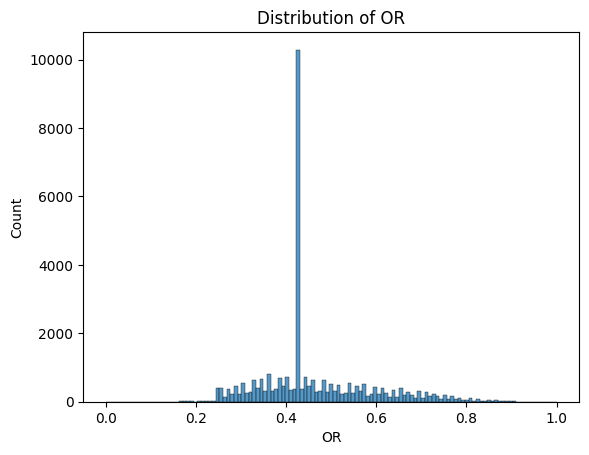

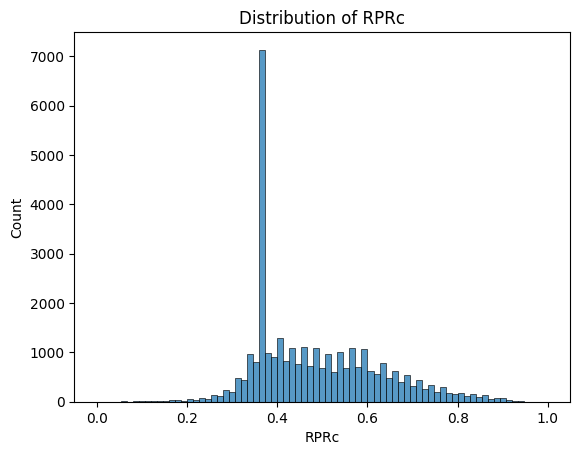

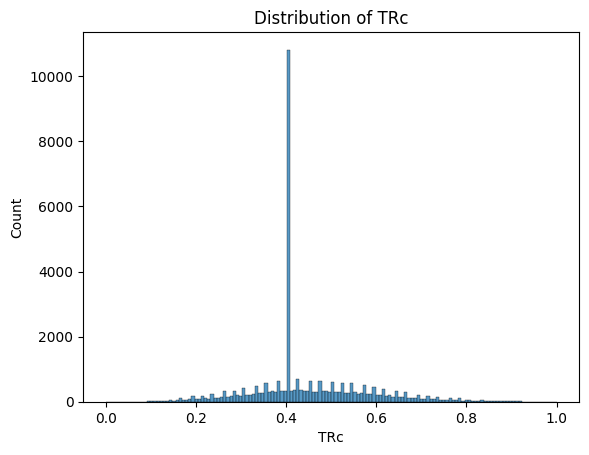

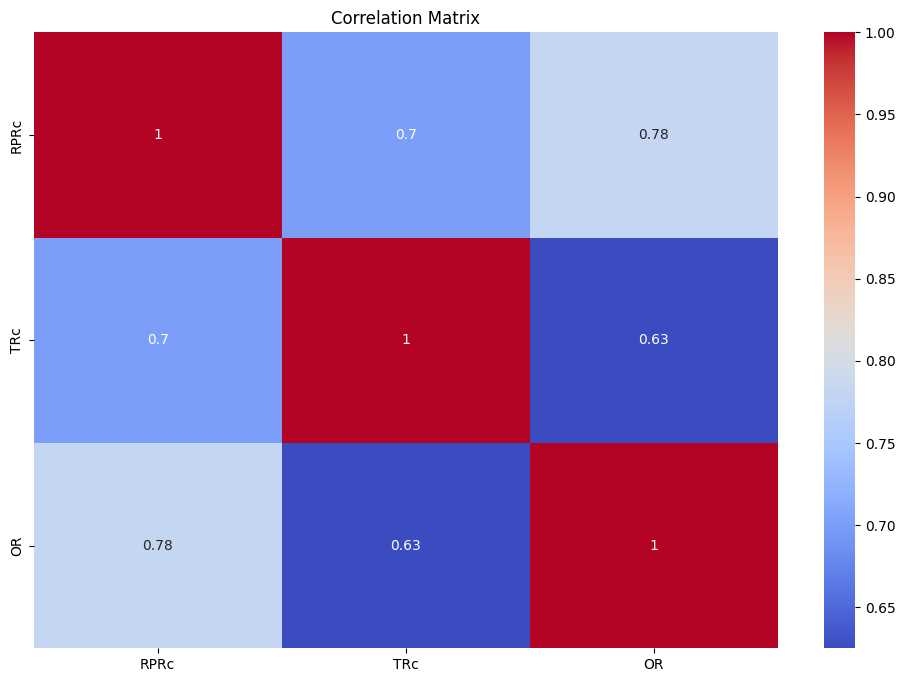

In [156]:
plot_distribution(forward_df, forward_numerical_cols)
plot_correlation(forward_df)

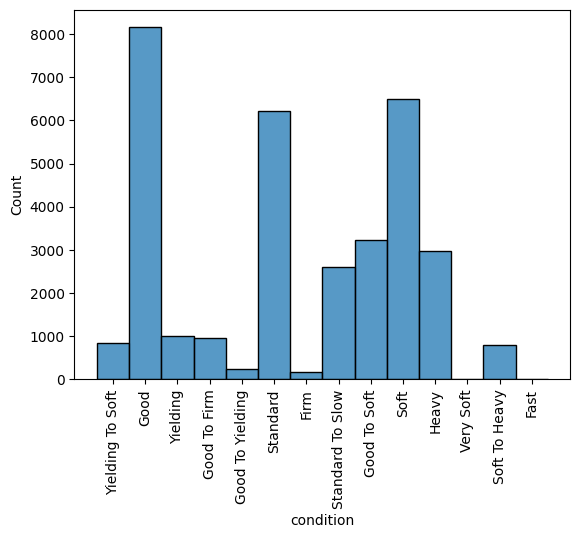

In [31]:
plt.figure()
sns.histplot(forward_df["condition"])
plt.xticks(rotation=90) 
plt.show()

In [16]:

# Convert 'horseName' to string in all DataFrames
horse_df['horseName'] = horse_df['horseName'].astype(str)
forward_df['horseName'] = forward_df['horseName'].astype(str)

# Merge horse and forward datasets on 'horseName'
horse_forward_df = pd.merge(horse_df, forward_df, on='horseName')

# Convert 'rid' to int to merge with race_df
horse_forward_df['rid'] = horse_forward_df['rid'].astype(int)
race_df['rid'] = race_df['rid'].astype(int)

# Merge the result with the race dataset on 'rid'
merged_df = pd.merge(horse_forward_df, race_df, on='rid')

# Inspect the columns to get the exact names
print(merged_df.columns)

Index(['rid', 'horseName', 'age_x', 'saddle', 'decimalPrice_x', 'isFav',
       'trainerName_x', 'jockeyName_x', 'position', 'positionL', 'dist',
       'weightSt_x', 'weightLb_x', 'overWeight', 'outHandicap', 'headGear',
       'RPR', 'TR', 'OR_x', 'father', 'mother', 'gfather', 'runners_x',
       'margin', 'weight', 'res_win', 'res_place', 'price', 'course_x',
       'countryCode_x', 'marketTime', 'title_x', 'runners_y', 'condition_x',
       'prize_x', 'rclass_x', 'trainerName_y', 'jockeyName_y', 'RPRc', 'TRc',
       'OR_y', 'weightSt_y', 'weightLb_y', 'age_y', 'decimalPrice_y',
       'course_y', 'time', 'date', 'title_y', 'rclass_y', 'band', 'ages',
       'distance', 'condition_y', 'hurdles', 'prizes', 'winningTime',
       'prize_y', 'metric', 'countryCode_y', 'ncond', 'class', 'currency'],
      dtype='object')


<Figure size 1200x600 with 0 Axes>

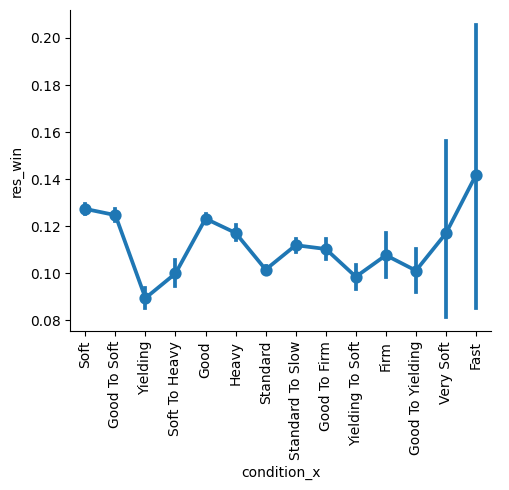

In [24]:
plt.figure(figsize=(12, 6))
sns.catplot(kind='point', data=merged_df, x='condition_x', y='res_win')
plt.xticks(rotation=90)  # rotate the x-axis tick labels by 90 degrees
plt.tight_layout()  # adjust the layout to make room for the rotated labels
plt.show()

<Figure size 640x480 with 0 Axes>

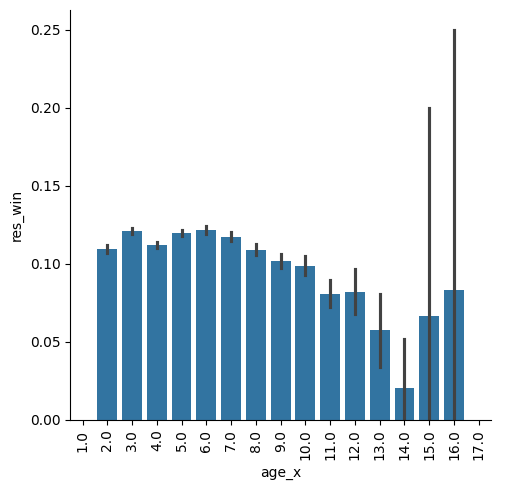

In [32]:
plt.figure()
sns.catplot(kind='bar', data=merged_df, x='age_x', y='res_win')
plt.xticks(rotation=90)  # rotate the x-axis tick labels by 90 degrees
plt.tight_layout()  # adjust the layout to make room for the rotated labels
plt.show()

<Figure size 640x480 with 0 Axes>

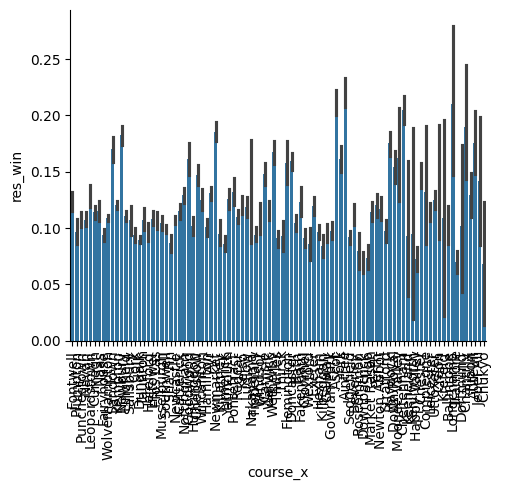

In [45]:
plt.figure()
sns.catplot(kind='bar', data=merged_df, x='course_x', y='res_win')
plt.xticks(rotation=90)  # rotate the x-axis tick labels by 90 degrees
plt.tight_layout()  # adjust the layout to make room for the rotated labels
plt.show()

<Axes: xlabel='res_win', ylabel='Count'>

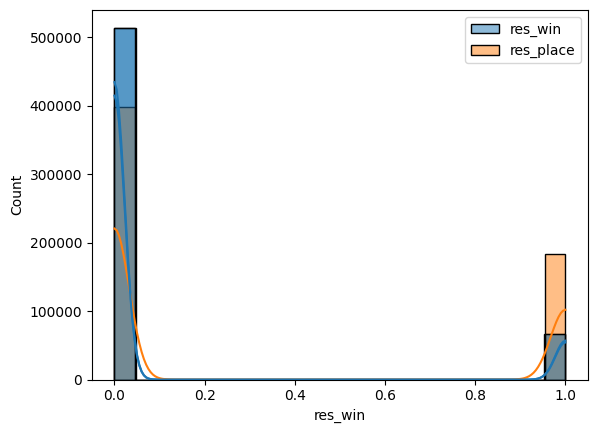

In [50]:
sns.histplot(merged_df['res_win'], kde=True)

# Histogram of multiple variables
sns.histplot(merged_df[['res_win', 'res_place']], kde=True)

<Figure size 640x480 with 0 Axes>

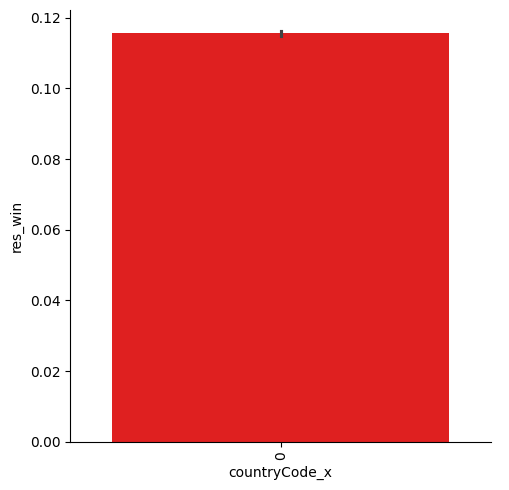

<Figure size 640x480 with 0 Axes>

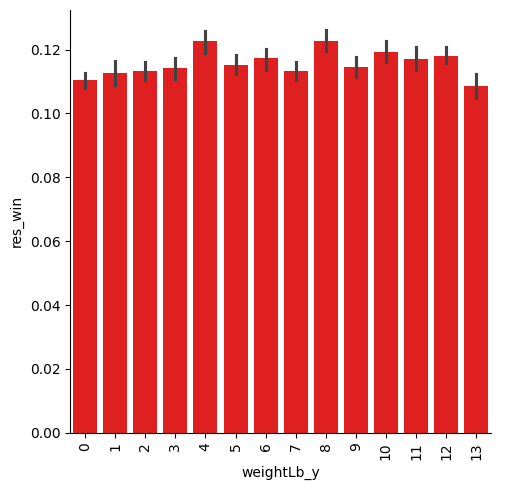

In [48]:
plt.figure()
sns.catplot(kind='bar', data=merged_df, x='countryCode_x', y='res_win',color="red")
plt.xticks(rotation=90)  # rotate the x-axis tick labels by 90 degrees
plt.tight_layout()  # adjust the layout to make room for the rotated labels
plt.show()

plt.figure()
sns.catplot(kind='bar', data=merged_df, x='weightLb_y', y='res_win',color="red")
plt.xticks(rotation=90)  # rotate the x-axis tick labels by 90 degrees
plt.tight_layout()  # adjust the layout to make room for the rotated labels
plt.show()